In [1]:
import pandas as pd
from numpy import squeeze
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
dat = pd.read_csv('californiaHousing.csv')
dat.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000).

In [3]:
X_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Y_name = ['MedHouseVal']
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
dat.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


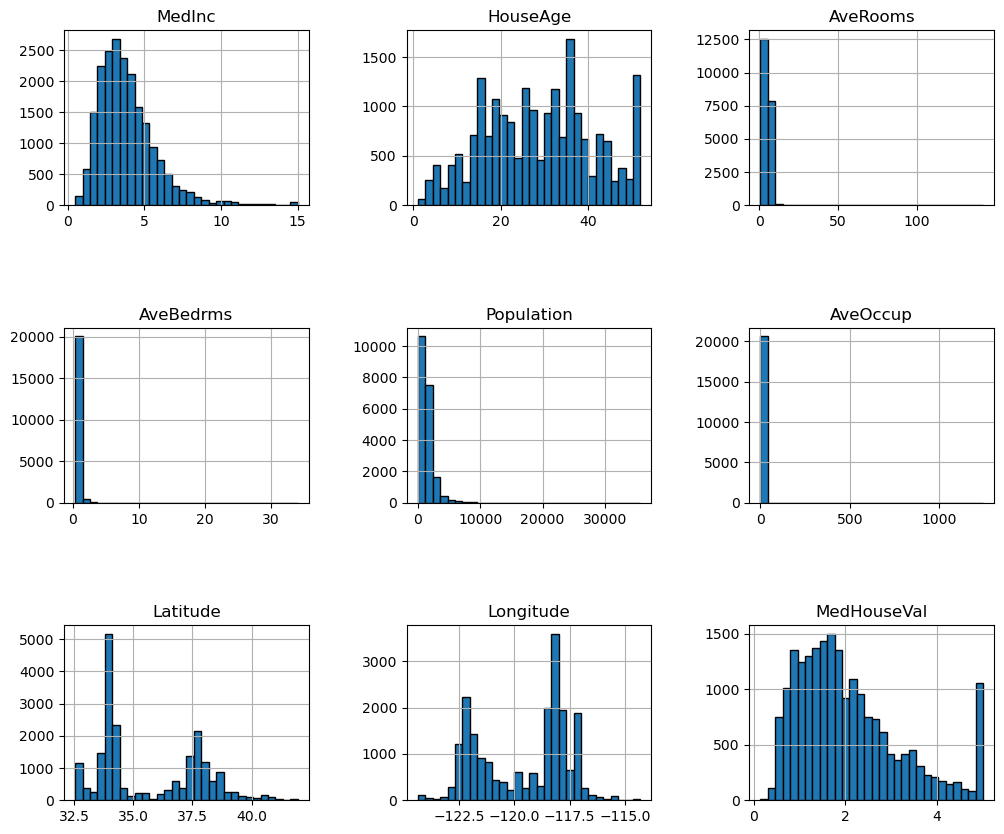

In [5]:

dat.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [6]:
X = dat[X_names]
y = dat[Y_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = squeeze(y_train)


### Linear SVR

In [7]:
model_l = SVR(kernel='linear' , C=0.01)
model_l.fit(X_train_scaled, y_train)
y_pred_l = model_l.predict(X_test_scaled)
rmse_l = root_mean_squared_error(y_test, y_pred_l)

print(f"(RMSE): {rmse_l}")

(RMSE): 0.8216813906207877


This is just an initial SVR_linear model, with low cost (the penalty for errors). The base value for cost is 1, but the model cannot be trained even in 30 mins with basic value.

So, the GridSearchSV will be used for redused range of costs, including a few numbers that below 1.

*Upd: last version exequted with cost >1.*


In [8]:

param_grid = {
    'kernel': ['linear'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_search_linear = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_linear.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search_linear.best_params_)

best_svr_linear = grid_search_linear.best_estimator_
y_pred_linear = best_svr_linear.predict(X_test_scaled)

print("RMSE:", root_mean_squared_error(y_test,y_pred_linear))


Best Parameters: {'C': 10, 'kernel': 'linear'}
RMSE: 0.7483563089506973


I struggled i little bit with linear SVM, because when I initialize for the first time via "SVR(kernel='linear')" the time of execution was infinite.

But with "GridSearchCV()" it executed and the best linear SVM model has cost equals 10. The RMSE is 0.748, which is actually quite high, because the range of the target variable is 0.14-5.0.

### poly SVR

In [9]:

model_poly = SVR(kernel='poly', C=0.01) 
model_poly.fit(X_train_scaled, y_train)
y_pred_p = model_poly.predict(X_test_scaled)
rmse_p = root_mean_squared_error(y_test, y_pred_p)

print(f"(RMSE): {rmse_p}")

(RMSE): 0.8050640398273017


Initial polinomial SVM model has higher RMSE

In [10]:
param_grid = {
    'kernel': ['poly'],
    'C': [0.01, 0.1, 1, 5, 10],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}
grid_search_poly = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_poly.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search_poly.best_params_)
best_svr_poly = grid_search_poly.best_estimator_

y_pred_poly = best_svr_poly.predict(X_test_scaled)

print("RMSE:", root_mean_squared_error(y_test,y_pred_poly))

Best Parameters: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
RMSE: 0.7458830521727737


But the tuned model performs better

The parametres:
- cost -> 1
- degree -> 3
- gamma -> 'scale' = 1/(n_features * X.var())

If we calculate it manually the gamma in our case equals 1/(8*(1.153956)^2) = 0.09387
I've got σ=1.153956 from dat.describe(), therefore the X.var() = σ^2.

The last parameter also could be 'auto', which is simply 1/n_features (0.125)

### Radial-Basis-Function (rbf) SVR

In [11]:

model_b = SVR(kernel='rbf')
model_b.fit(X_train_scaled, y_train)
y_pred_b = model_b.predict(X_test_scaled)
rmse_b = root_mean_squared_error(y_test, y_pred_b)

print(f"(RMSE): {rmse_b}")

(RMSE): 0.6904757531208597


Initial rbf SVM performed similary to initial polynomial SVM in terms of RMSE, which is still worse then initial linear model.

In [12]:
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}
grid_search_rbf = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search_rbf.best_params_)
best_svr_rbf = grid_search_rbf.best_estimator_
y_pred_rbf = best_svr_rbf.predict(X_test_scaled)

print("RMSE:", root_mean_squared_error(y_test,y_pred_rbf))

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
RMSE: 0.6649149343027548


But after tuning the parametres it shows the best performance, since we have the lowest RMSE comparing to other types of SVM (also tuned). 

## Performance plot

For easier understanding we plot the number of support vectors VS. RMSE for created models.

True


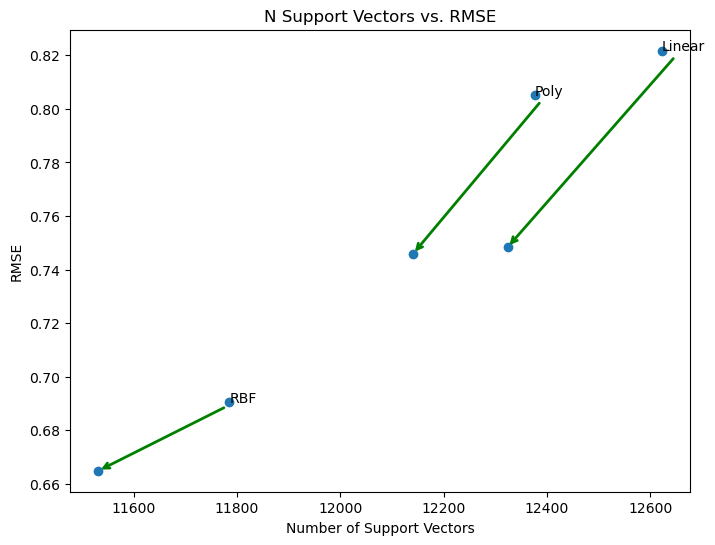

In [13]:
print(len(best_svr_rbf.support_vectors_)==best_svr_rbf.support_.size)

n_sv = [best_svr_linear.support_.size,
        best_svr_poly.support_.size,
        best_svr_rbf.support_.size,
        model_l.support_.size,
        model_poly.support_.size,
        model_b.support_.size]

rmse_list = [ root_mean_squared_error(y_test,y_pred_linear),
        root_mean_squared_error(y_test,y_pred_poly),
        root_mean_squared_error(y_test,y_pred_rbf),
        rmse_l,
        rmse_p,
        rmse_b]

# points
linear_svr_initial = (model_l.support_.size, rmse_l)
linear_svr_best = (best_svr_linear.support_.size, 
              rmse_list[0])

poly_svr_initial = (model_poly.support_.size, rmse_p)
poly_svr_best = (best_svr_poly.support_.size, 
              rmse_list[1])

rbf_svr_initial = (model_b.support_.size, rmse_b)
rbf_svr_best = (best_svr_rbf.support_.size, 
              rmse_list[2])


plt.figure(figsize=(8, 6))
plt.scatter(n_sv, rmse_list)
plt.annotate(
    "Linear",
    xytext=linear_svr_initial,
    xy=linear_svr_best,
    arrowprops=dict(arrowstyle="->", color="green", lw=2)
)
plt.annotate(
    "Poly",
    xytext=poly_svr_initial,
    xy=poly_svr_best,
    arrowprops=dict(arrowstyle="->", color="green", lw=2)
)
plt.annotate(
    "RBF",
    xytext=rbf_svr_initial,
    xy=rbf_svr_best,
    arrowprops=dict(arrowstyle="->", color="green", lw=2)
)
plt.xlabel("Number of Support Vectors")
plt.ylabel("RMSE")
plt.title("N Support Vectors vs. RMSE")
plt.show()

The arrows connect the initial models with respective tuned models. The largest improvement in terms of decreasing RMSE is showed by Polynomial SVM, while the lowest improvement by RBF_SVM. But both initial and tuned RBF_SVM are better than other models. 

## Linear regression models
- LinearRegression (without regularization)
- Lasso,  which takes into account the L1 regularization (sum of absolute values of weights) to avoid overfitting
- Ridge, which takes into account the L2 regularization (sum of squared weights)

### LinearRegression without regularization

In [14]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_pred_lm = lm.predict(X_test_scaled)

rmse_lm = root_mean_squared_error(y_test, y_pred_lm)
print("RMSE:", rmse_lm)

RMSE: 0.7329424451212703


### L1 regularization

In [15]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

best_lasso = grid_search.best_estimator_

y_pred_lasso = best_lasso.predict(X_test_scaled)

rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
print("RMSE:", rmse_lasso)

Best Parameters: {'alpha': 0.001}
RMSE: 0.7457135722601448


### L2 regularization

In [16]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

best_ridge = grid_search.best_estimator_

y_pred_ridge = best_ridge.predict(X_test_scaled)

rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
print("RMSE:", rmse_ridge)

Best Parameters: {'alpha': 0.1}
RMSE: 0.7338474280843222


To compare the linear regression models with linear SVM we can compare the coefficients of these models.

In [31]:
print(best_svr_linear.coef_[0])
print(lm.coef_)
print(best_lasso.coef_)
print(best_ridge.coef_)

[  6.58217026   0.35489227 -13.08079316  21.82795131   0.14474971
  -5.42209603  -3.40351451  -3.87164375]
[  6.37285765   0.46979619 -14.3547206   20.40349142  -0.24148586
  -4.10932316  -3.92546226  -4.34125679]
[ 5.50711399  0.49147262  0.          0.         -0.         -0.
 -3.90260319 -4.24592827]
[ 6.10785125  0.47484964 -9.88089612 15.00960526 -0.22635285 -3.75090912
 -4.03121599 -4.43736124]


In [32]:
df = pd.DataFrame.from_dict(
    {"svr_linear": best_svr_linear.coef_[0],
     "lm": lm.coef_,
     "lasso":best_lasso.coef_,
     "ridge": best_ridge.coef_
    }, 
    orient='index', columns=X_test.columns
)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
svr_linear,6.582170,0.354892,-13.080793,21.827951,0.144750,-5.422096,-3.403515,-3.871644
lm,6.372858,0.469796,-14.354721,20.403491,-0.241486,-4.109323,-3.925462,-4.341257
lasso,5.507114,0.491473,0.000000,0.000000,-0.000000,-0.000000,-3.902603,-4.245928
ridge,6.107851,0.474850,-9.880896,15.009605,-0.226353,-3.750909,-4.031216,-4.437361


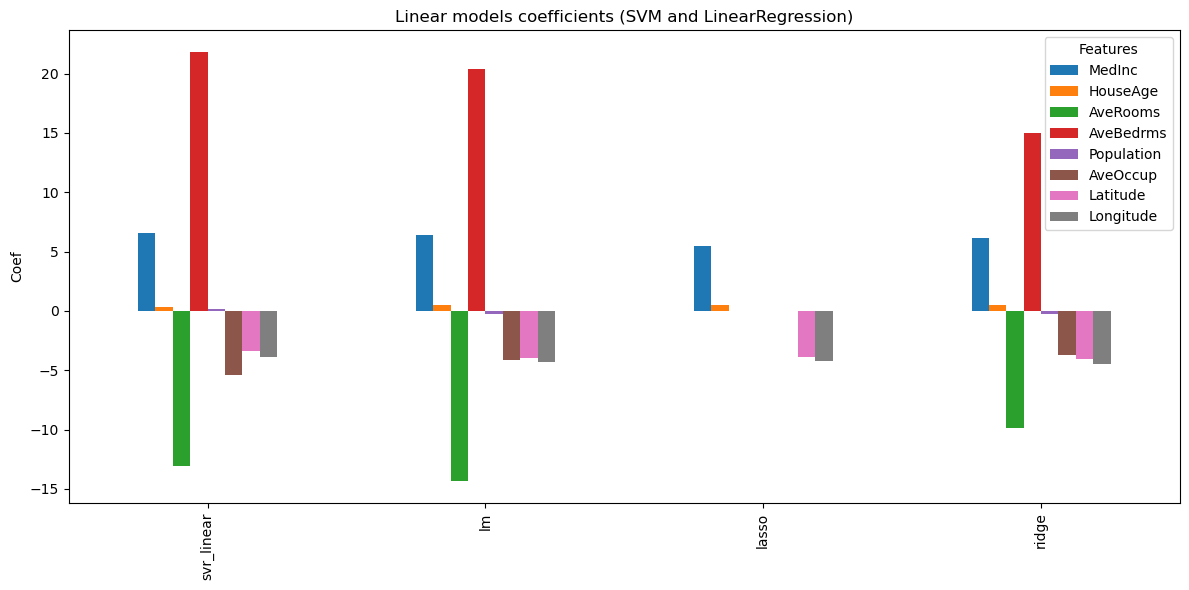

In [33]:
ax = df.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Coef')
ax.set_title('Linear models coefficients (SVM and LinearRegression)')
ax.legend(title='Features')

plt.tight_layout()
plt.show()

Coefficients of svr_linear and LM models are close to each other, which make sence, because these models estimates the best linear model that can be created using the data.

L1 regularization deliminishes the half of the predictors, but the picture that we see for AveRooms (negative coef) and AveBedrms (positive coef, but > AveRooms) is quite strange, so the 0 values for these coefs are more sutable. May be this is because of multycolinearity, sinse AveRooms and AveBedrms are very close in the meaning. 

L2 regularization just reduce the coefs of the features with largest weighs in basic lm.

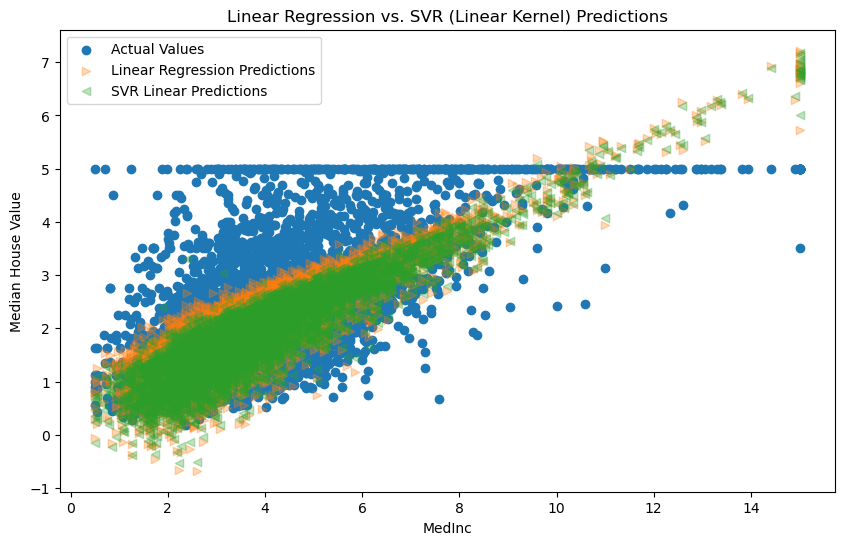

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test['MedInc'], y_test, label='Actual Values', )
plt.scatter(X_test['MedInc'], y_pred_lm, label='Linear Regression Predictions', alpha=0.3, marker= ">")
plt.scatter(X_test['MedInc'], y_pred_linear, label='SVR Linear Predictions', alpha=0.3,  marker= "<")
plt.xlabel('MedInc')
plt.ylabel('Median House Value')
plt.title('Linear Regression vs. SVR (Linear Kernel) Predictions')
plt.legend()
plt.show()

One feture that was picked to demonstrate the svr_linear and LM in prediction performance is Median Income. Both models predict the values in appropriate for linear models shape. Unfortunatelly the target value is overestimated for districts with median income more that 11, but the linear model can not perform better in case we have boudared above target variable.

## Shrinkage model

Shrinkage medel combines the L1 and L2 regularizations, that means both additional summands in the objective loss function but in specific ratio. This rati in sklearn corresponded by "l1_ratio", that scales from 0 to 1. https://scikit-learn.ru/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet. If we expect many features to be irrelevant, a higher l1_ratio (closer to Lasso) will be better. If we expect most features to be relevant, a lower l1_ratio (closer to Ridge) will be better.

To determine the best "l1_ratio" the GridSearchCV method will be used, as well as in previous models.

In [35]:
elastic_net = ElasticNet()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)

best_elastic_net = grid_search.best_estimator_

y_pred_en = best_elastic_net.predict(X_test_scaled)
rmse_en = root_mean_squared_error(y_test, y_pred_en)
print(f"RMSE: {rmse_en:.4f}")

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.9}
RMSE: 0.7459


The best "l1_ratio" is 0.9 (maximum in the listed), so the best model is closer to Lasso regularization.

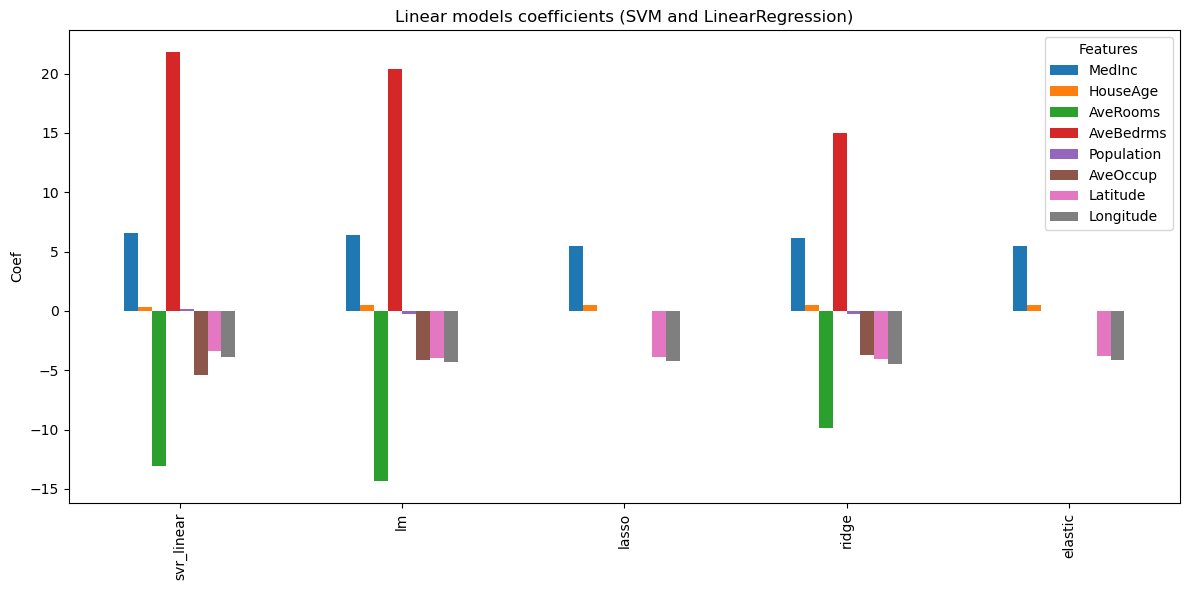

In [36]:
df = pd.DataFrame.from_dict(
    {"svr_linear": best_svr_linear.coef_[0],
     "lm": lm.coef_,
     "lasso":best_lasso.coef_,
     "ridge": best_ridge.coef_,
     "elastic": best_elastic_net.coef_
    }, 
    orient='index', columns=X_test.columns
)
ax = df.plot(kind='bar', figsize=(12, 6))
ax.set_ylabel('Coef')
ax.set_title('Linear models coefficients (SVM and LinearRegression)')
ax.legend(title='Features')

plt.tight_layout()
plt.show()

We also can see on coef plot that the elastic model is quite similar to lasso model in terms of coefficients. 

But still the lowest RMSE = 0.7329 we have in the basic linear model among Linear regression models.

Overall, the best model is SVR based on Radial-Basis-Function in terms of RMSE (0.6649). The unexpectfull thing is that the polynomial model performed worse or not better than linear models